In [31]:
import numpy as np
import pandas as pd
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
class Layers:
    def __init__(self,input_dim,output_dim,activation="sigmoid"): 
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation
        self.W = np.random.randn(output_dim,input_dim) * np.sqrt(2/input_dim)
        self.b = np.zeros((output_dim,1))
        self.db = np.zeros((output_dim,1))
        self.H = None
        self.A = None
        self.dW = np.zeros((output_dim,input_dim))
        self.dH = None
    def activated_values(self,X):
        if self.activation == "sigmoid":
            A = np.clip(X, -500, 500)
            sig = 1 / (1 + np.exp(-A))
            return sig 
        if self.activation == "ReLU":
            relu = lambda x: x if x > 0 else 0
            return np.vectorize(relu)(X)
        if self.activation == "linear":
            return X 
        if self.activation == "Softmax":
            X = np.clip(X, -500, 500)  # Clipping to avoid overflow
            exps = np.exp(X - np.max(X, axis=0, keepdims=True))
            return exps / np.sum(exps, axis=0, keepdims=True)
        
    def dactivation_da(self,A):
        if self.activation == "sigmoid":
            A = np.clip(A, -500, 500)
            return 1/(1+np.exp(-A)) * (1 - 1/(1+np.exp(-A)))
        if self.activation == "ReLU":
            return np.where(A > 0, 1, 0)
        if self.activation == "linear":
            return np.ones_like(A)

class NeuralNetwork:
    def __init__(self, layers):
        self.layers = layers
        self.uW = []
        self.ub = []
        for layer in layers:
            self.uW.append(np.zeros((layer.dW.shape[0],layer.dW.shape[1])))
            self.ub.append(np.zeros((layer.db.shape[0],layer.db.shape[1])))
    
    def forward(self,X):
        self.layers[0].A = self.layers[0].W @ X + self.layers[0].b
        self.layers[0].H = self.layers[0].activated_values(self.layers[0].A)
        for i in range(1,len(self.layers)):
            self.layers[i].A = self.layers[i].W @ self.layers[i-1].H + self.layers[i].b
            self.layers[i].H = self.layers[i].activated_values(self.layers[i].A)
        return self.layers[i].H
    
    def backPropagation(self,X,Y):
        encoded_Y = np.zeros((Y.shape[0],np.max(Y)+1))
        encoded_Y[np.arange(Y.shape[0]),Y] = 1
        n = len(self.layers)
        for i in range(n):
            self.layers[i].dW = np.zeros_like(self.layers[i].dW) 
            self.layers[i].db = np.zeros_like(self.layers[i].db)
        for x, encoded_y in zip(X, encoded_Y):
            x = x.reshape(-1,1)
            encoded_y = encoded_y.reshape(-1,1)
            y_pred = self.forward(x)
            dL_da = - (encoded_y - y_pred)
            for i in range(n-1,0,-1):
                self.layers[i].dW +=  dL_da @(self.layers[i-1].H).T
                self.layers[i].db += dL_da.reshape(-1,1)
                dL_dh = (self.layers[i].W).T @ dL_da
                dL_da = dL_dh * self.layers[i-1].dactivation_da(self.layers[i-1].A)
            self.layers[0].dW += dL_da @ (x.T)
            self.layers[0].db += dL_da.reshape(-1,1)

    def update_step(self,X,Y,beta,optimiser):
        if optimiser == "momemtum":
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = beta*self.uW[i] + self.layers[i].dW
                self.ub[i] = beta*self.ub[i] + self.layers[i].db
            return self.uW,self.ub

        if optimiser == "nesterov":
            weights,bias = [],[]
            for i in range(len(self.layers)):
                weights.append(self.layers[i].W.copy())
                bias.append(self.layers[i].b.copy())
                self.layers[i].W = self.layers[i].W - beta*self.uW[i]
                self.layers[i].b = self.layers[i].b - beta*self.ub[i]
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = beta*self.uW[i] + self.layers[i].dW
                self.ub[i] = beta*self.ub[i] + self.layers[i].db
                self.layers[i].W = weights[i]
                self.layers[i].b = bias[i]
            return self.uW,self.ub

        if optimiser == "RMSprop":
            epsilon = 1e-8  
            grad_w,grad_b = [],[]
            self.backPropagation(X,Y)
            for i in range(len(self.layers)):
                self.uW[i] = beta*self.uW[i] + (1-beta)*self.layers[i].dW**2
                self.ub[i] = beta*self.ub[i] + (1-beta)*self.layers[i].db**2
                grad_w.append(self.layers[i].dW/(np.sqrt(self.uW[i])+epsilon))
                grad_b.append(self.layers[i].db/(np.sqrt(self.ub[i])+epsilon))
            return grad_w,grad_b

    def gradient_descent(self,X,Y,beta,eta,optimiser,gradientDescent):
        
        if gradientDescent == "Vanilla":
            grad_w,gradb = self.update_step(X,Y,beta = beta,optimiser = optimiser)
            for i in range(len(self.layers)):
                self.layers[i].W -= eta*(grad_w[i])
                self.layers[i].b -= eta*(gradb[i])
                
        if gradientDescent == "Stochastic":
            for x, y in zip(X, Y):
                grad_w,gradb = self.update_step(np.array([x]), np.array([y]), beta=beta, optimiser=optimiser)
                for i in range(len(self.layers)):
                    self.layers[i].W -= eta*(grad_w[i])
                    self.layers[i].b -= eta*(gradb[i])
    
    def fit(self,X,y,beta,eta,epochs,optimiser = "momemtum",gradientDescent = "Vanilla",verbose = False):
        for epoch in range(1,epochs+1):
            self.gradient_descent(X,y,beta=beta,eta=eta,optimiser = optimiser,gradientDescent = gradientDescent)
            if verbose:
                y_pred = self.predict(X)
                accuracy = np.sum(y_pred==y)/len(y_pred)
                print(f"After epoch {epoch} the achieved accuracy is {accuracy}")

    def predict(self,X):
        Y = []
        for x in X:
            x = x.reshape(-1,1)
            y = self.forward(x)
            Y.append(np.argmax(y.reshape(-1)))
        return np.array(Y)


In [33]:
y1 = np.array([0,2,4,5,1,2,5])
y2 = np.array([1,2,4,5,3,2,5])
np.sum(y1 == y2)

5

In [34]:
def f(X):
    X = 1/(1+np.exp(-X))
    return X / np.sum(X)

In [35]:
X = np.arange(1,10).reshape(-1,3)
y = X.reshape(-1,1)
z = y + 2
y*z

array([[ 3],
       [ 8],
       [15],
       [24],
       [35],
       [48],
       [63],
       [80],
       [99]])

In [36]:
fashion_mnist_data = fashion_mnist.load_data()
train_data_x,train_data_y, test_data_x, test_data_y = fashion_mnist_data[0][0], fashion_mnist_data[0][1], fashion_mnist_data[1][0], fashion_mnist_data[1][1]
train_data_x, validation_data_x, train_data_y, validation_data_y = train_test_split(train_data_x, train_data_y, test_size=0.1)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


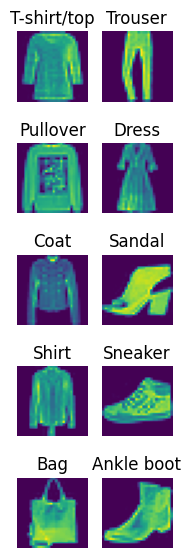

In [37]:
class_id,images_index_each_class = np.unique(train_data_y, return_index=True)
plt.figure(figsize=(2,7))
for i in range(10):
    plt.subplot(5,2,i+1)
    plt.imshow(train_data_x[images_index_each_class[i]])
    plt.title(class_names[class_id[i]])
    plt.axis('off')
plt.show()

In [38]:
model = NeuralNetwork([
    Layers(784,100),
    Layers(100,50),
    Layers(50,10,activation="Softmax"),
])

In [39]:
model.fit(X=train_data_x[:3000],y=train_data_y[:3000],beta=0,eta=1,epochs=5,optimiser="momemtum",gradientDescent="Vanilla",verbose=True)

After epoch 1 the achieved accuracy is 0.098
After epoch 2 the achieved accuracy is 0.101
After epoch 3 the achieved accuracy is 0.098
After epoch 4 the achieved accuracy is 0.101
After epoch 5 the achieved accuracy is 0.098


In [40]:
y_pred = model.predict(validation_data_x)
y_true = validation_data_y
accuracy = np.sum(y_pred==y_true)/len(y_pred)
accuracy

0.10266666666666667

In [41]:
train_data_y.shape
encoded_y = np.zeros((train_data_y.shape[0],np.max(train_data_y)+1))
encoded_y[np.arange(train_data_y.shape[0]),train_data_y] = 1


In [42]:
encoded_y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])